# Without Shadow Removal

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import ResNet152V2, VGG19, MobileNetV2, DenseNet201, EfficientNetB7
from keras.applications.resnet50 import preprocess_input
from keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%cd /content

!mkdir -p ./dataset
from google.colab import drive
drive.mount('/content/drive')

!unrar x /content/drive/MyDrive/road_surface_raw.rar /content/dataset > /dev/null #without shadow removal and enlightenGAN = road_surface2
!unrar x /content/drive/MyDrive/road_surface_shadow.rar /content/dataset > /dev/null #with shadow removal only = road_surface
!unrar x /content/drive/MyDrive/road_surface_processed.rar /content/dataset > /dev/null #with shadow removal and enlightenGAN = road_surface1

/content
Mounted at /content/drive


In [3]:
num_classes = 2
image_resize = 224
batch_size_training = 80
batch_size_validation = 80

In [4]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = data_generator.flow_from_directory(
    '/content/dataset/road_surface2/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    '/content/dataset/road_surface2/val',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 1646 images belonging to 2 classes.
Found 238 images belonging to 2 classes.


In [5]:
model = Sequential()
model.add(ResNet152V2(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"
    ))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.layers[0].trainable = False
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

234545216/234545216 [==============================] - 12s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                      

In [6]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

In [7]:
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-7-c12faaca829d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


Epoch 1/30
21/21 [==============================] - 98s 4s/step - loss: 1.0381 - accuracy: 0.7266 - val_loss: 4.1635 - val_accuracy: 0.4832
Epoch 2/30
21/21 [==============================] - 37s 2s/step - loss: 0.8481 - accuracy: 0.8384 - val_loss: 2.3291 - val_accuracy: 0.4790
Epoch 3/30
21/21 [==============================] - 35s 2s/step - loss: 0.7941 - accuracy: 0.8420 - val_loss: 1.4479 - val_accuracy: 0.5630
Epoch 4/30
21/21 [==============================] - 36s 2s/step - loss: 0.8033 - accuracy: 0.8408 - val_loss: 1.6377 - val_accuracy: 0.5126
Epoch 5/30
21/21 [==============================] - 35s 2s/step - loss: 0.7399 - accuracy: 0.8609 - val_loss: 1.7591 - val_accuracy: 0.4958
Epoch 6/30
21/21 [==============================] - 36s 2s/step - loss: 0.7112 - accuracy: 0.8597 - val_loss: 1.8277 - val_accuracy: 0.4664
Epoch 7/30
21/21 [==============================] - 36s 2s/step - loss: 0.7127 - accuracy: 0.8603 - val_loss: 1.7687 - val_accuracy: 0.5000
Epoch 8/30
21/21 [==

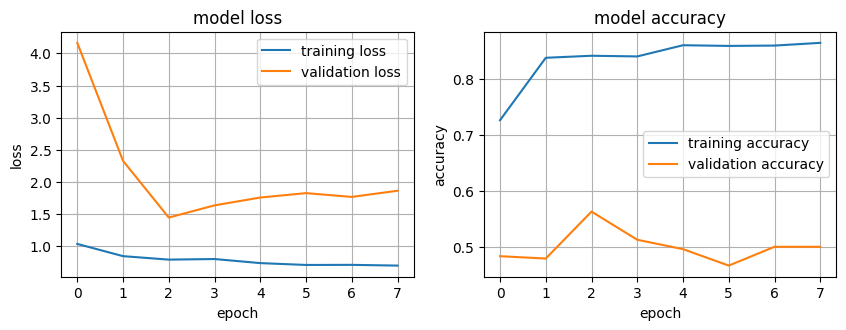

In [8]:
fig = plt.figure(figsize =  (10,7))

plt.subplot(221)
plt.plot(fit_history.history['loss'], label='training loss')
plt.plot(fit_history.history['val_loss'], label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.subplot(222)
plt.plot(fit_history.history['accuracy'], label='training accuracy')
plt.plot(fit_history.history['val_accuracy'], label='validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.show()

In [9]:
data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,)

test_generator = data_generator_test.flow_from_directory(
    '/content/dataset/road_surface2/test',
    target_size=(image_resize, image_resize),
    shuffle=False)

Found 470 images belonging to 2 classes.


<ipython-input-10-533a56fa025f>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, steps=None)  # Predicted labels


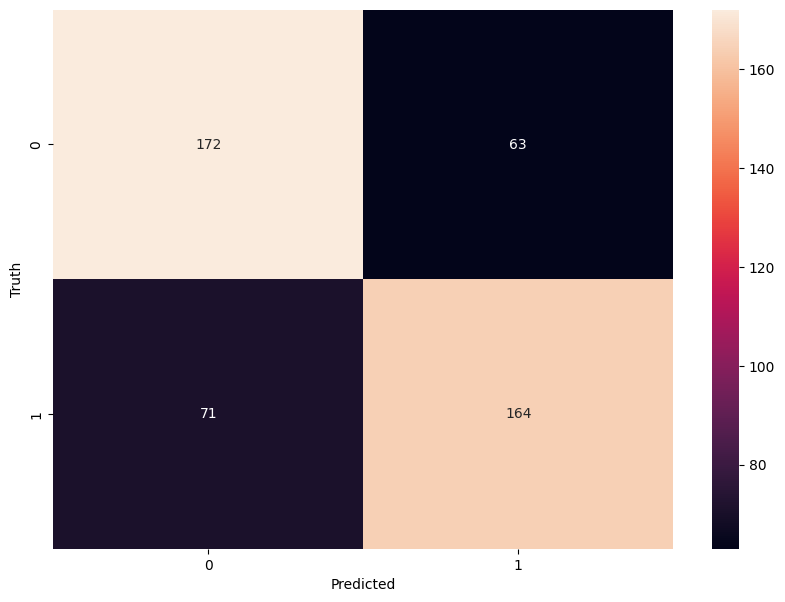

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes  # Ground truth labels
y_pred = model.predict_generator(test_generator, steps=None)  # Predicted labels
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Compute the confusion matrix
cm=confusion_matrix = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.7224669603524229
Recall: 0.6978723404255319
F1 score: 0.7099567099567099


In [12]:
test_loss, test_accuracy = model.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

<ipython-input-12-2e5b5b2d6e1f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)


Test Loss: 1.1547572612762451
Test Accuracy: 0.714893639087677


# With Shadow Removal

In [17]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = data_generator.flow_from_directory(
    '/content/dataset/road_surface/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    '/content/dataset/road_surface/val',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 1646 images belonging to 2 classes.
Found 238 images belonging to 2 classes.


In [18]:
model1 = Sequential()
model1.add(ResNet152V2(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model1.layers[0].trainable = False
model1.summary()
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 256)              

In [19]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

In [20]:
fit_history1 = model1.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-20-c00f0094c4a5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history1 = model1.fit_generator(


Epoch 1/30
21/21 [==============================] - 61s 2s/step - loss: 1.1848 - accuracy: 0.6604 - val_loss: 3.7444 - val_accuracy: 0.4664
Epoch 2/30
21/21 [==============================] - 48s 2s/step - loss: 0.9313 - accuracy: 0.7691 - val_loss: 2.0477 - val_accuracy: 0.5042
Epoch 3/30
21/21 [==============================] - 36s 2s/step - loss: 0.8655 - accuracy: 0.7819 - val_loss: 1.9939 - val_accuracy: 0.4706
Epoch 4/30
21/21 [==============================] - 35s 2s/step - loss: 0.8689 - accuracy: 0.7904 - val_loss: 1.8070 - val_accuracy: 0.4748
Epoch 5/30
21/21 [==============================] - 43s 2s/step - loss: 0.8620 - accuracy: 0.7855 - val_loss: 1.4825 - val_accuracy: 0.5294
Epoch 6/30
21/21 [==============================] - 34s 2s/step - loss: 0.8014 - accuracy: 0.8123 - val_loss: 1.4254 - val_accuracy: 0.5504
Epoch 7/30
21/21 [==============================] - 37s 2s/step - loss: 0.8370 - accuracy: 0.8007 - val_loss: 1.4429 - val_accuracy: 0.4916
Epoch 8/30
21/21 [==

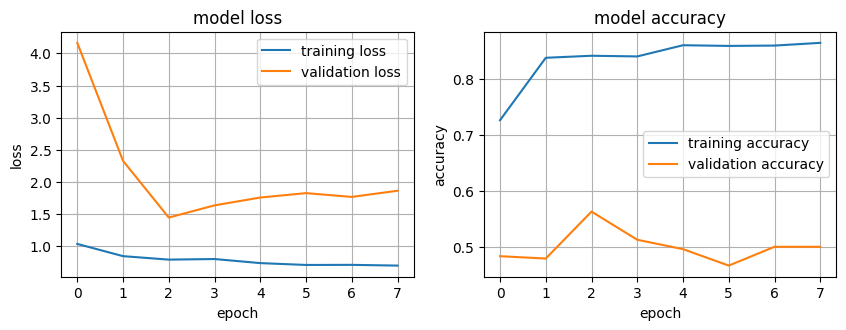

In [21]:
fig = plt.figure(figsize =  (10,7))

plt.subplot(221)
plt.plot(fit_history.history['loss'], label='training loss')
plt.plot(fit_history.history['val_loss'], label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.subplot(222)
plt.plot(fit_history.history['accuracy'], label='training accuracy')
plt.plot(fit_history.history['val_accuracy'], label='validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.show()

In [22]:
data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,)

test_generator = data_generator_test.flow_from_directory(
    '/content/dataset/road_surface/test',
    target_size=(image_resize, image_resize),
    shuffle=False)

Found 470 images belonging to 2 classes.


<ipython-input-23-18a9dff66062>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(test_generator, steps=None)  # Predicted probabilities


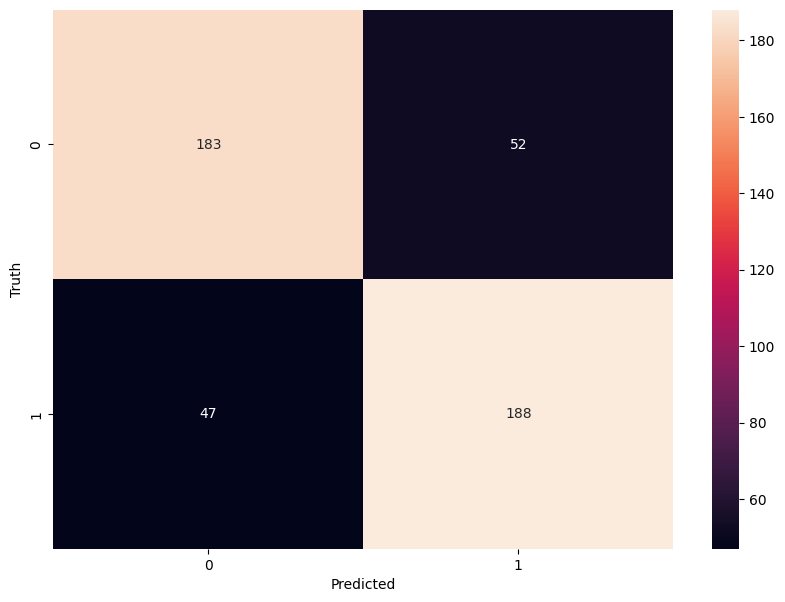

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes  # Ground truth labels
y_pred = model1.predict_generator(test_generator, steps=None)  # Predicted probabilities

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.7833333333333333
Recall: 0.8
F1 score: 0.791578947368421


In [25]:
test_loss1, test_accuracy1 = model1.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
print('Test Loss:', test_loss1)
print('Test Accuracy:', test_accuracy1)

<ipython-input-25-0b1e45ffdc21>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss1, test_accuracy1 = model1.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)


Test Loss: 0.8262770175933838
Test Accuracy: 0.7893617153167725


# With Shadow Removal and EnlightenGAN
## ResNet152

In [26]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = data_generator.flow_from_directory(
    '/content/dataset/road_surface1/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    '/content/dataset/road_surface1/val',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 1646 images belonging to 2 classes.
Found 238 images belonging to 2 classes.


In [27]:
model2 = Sequential()
model2.add(ResNet152V2(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model2.layers[0].trainable = False
model2.summary()
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 batch_normalization_9 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_10 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 256)              

In [28]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

fit_history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-28-915ad319d9ae>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history2 = model2.fit_generator(


Epoch 1/30
21/21 [==============================] - 36s 2s/step - loss: 0.5278 - accuracy: 0.9344 - val_loss: 14.3285 - val_accuracy: 0.5000
Epoch 3/30
21/21 [==============================] - 35s 2s/step - loss: 0.5350 - accuracy: 0.9301 - val_loss: 9.3804 - val_accuracy: 0.5000
Epoch 4/30
21/21 [==============================] - 35s 2s/step - loss: 0.5320 - accuracy: 0.9253 - val_loss: 6.1667 - val_accuracy: 0.5126
Epoch 5/30
21/21 [==============================] - 35s 2s/step - loss: 0.5082 - accuracy: 0.9374 - val_loss: 4.1716 - val_accuracy: 0.5924
Epoch 6/30
21/21 [==============================] - 35s 2s/step - loss: 0.5184 - accuracy: 0.9326 - val_loss: 2.5527 - val_accuracy: 0.7437
Epoch 7/30
21/21 [==============================] - 35s 2s/step - loss: 0.4784 - accuracy: 0.9459 - val_loss: 1.9793 - val_accuracy: 0.7941
Epoch 8/30
21/21 [==============================] - 36s 2s/step - loss: 0.5087 - accuracy: 0.9368 - val_loss: 1.6969 - val_accuracy: 0.8235
Epoch 9/30
21/21 [=

In [29]:
data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,)

test_generator = data_generator_test.flow_from_directory(
    '/content/dataset/road_surface1/test',
    target_size=(image_resize, image_resize),
    shuffle=False)

Found 470 images belonging to 2 classes.


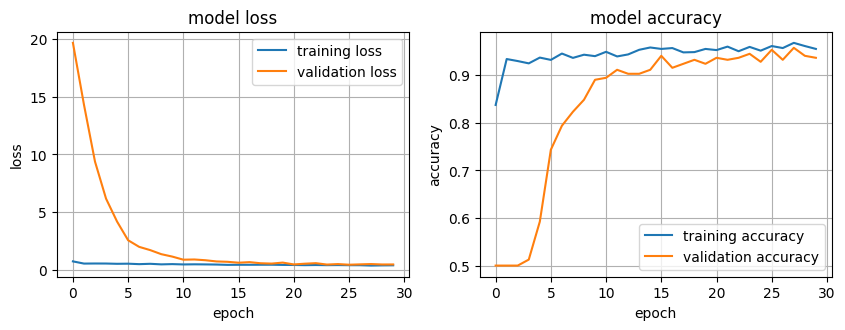

In [30]:
fig = plt.figure(figsize =  (10,7))

plt.subplot(221)
plt.plot(fit_history2.history['loss'], label='training loss')
plt.plot(fit_history2.history['val_loss'], label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.subplot(222)
plt.plot(fit_history2.history['accuracy'], label='training accuracy')
plt.plot(fit_history2.history['val_accuracy'], label='validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.show()

<ipython-input-31-d2fac68f460c>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model2.predict_generator(test_generator, steps=None)  # Predicted probabilities


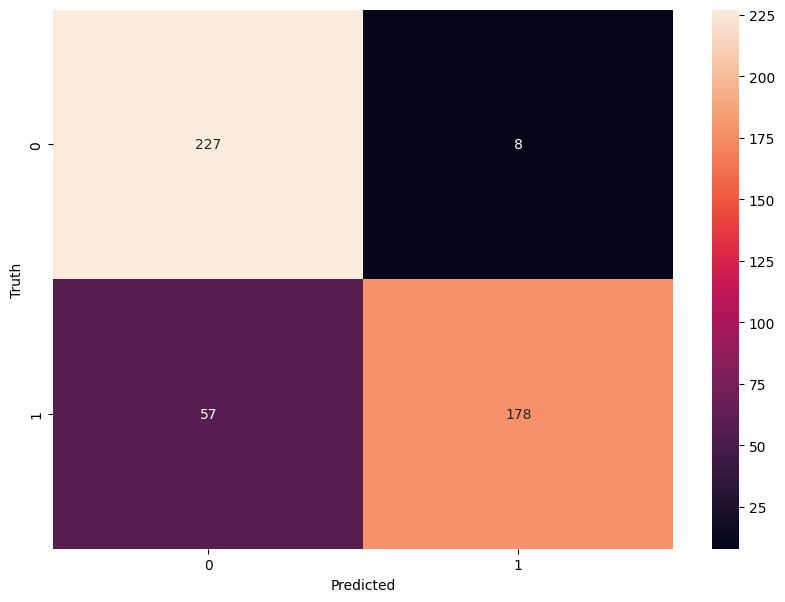

In [31]:
y_true = test_generator.classes  # Ground truth labels
y_pred = model2.predict_generator(test_generator, steps=None)  # Predicted probabilities

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.956989247311828
Recall: 0.7574468085106383
F1 score: 0.8456057007125891


In [34]:
test_loss2, test_accuracy2 = model2.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
print('Test Loss:', test_loss2)
print('Test Accuracy:', test_accuracy2)

<ipython-input-34-f4935018527a>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss2, test_accuracy2 = model2.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)


Test Loss: 0.7110422849655151
Test Accuracy: 0.8617021441459656


## VGG19

In [35]:
model3 = Sequential()
model3.add(VGG19(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"
    ))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))
model3.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model3.layers[0].trainable = False
model3.summary()
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 batch_normalization_12 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                       

In [36]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

fit_history3 = model3.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-36-b03dc3c78e3a>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history3 = model3.fit_generator(


Epoch 1/30
21/21 [==============================] - 70s 2s/step - loss: 1.3242 - accuracy: 0.5741 - val_loss: 1.3045 - val_accuracy: 0.5042
Epoch 2/30
21/21 [==============================] - 35s 2s/step - loss: 1.1162 - accuracy: 0.6385 - val_loss: 1.0362 - val_accuracy: 0.5714
Epoch 3/30
21/21 [==============================] - 33s 2s/step - loss: 1.0264 - accuracy: 0.6810 - val_loss: 0.9029 - val_accuracy: 0.7101
Epoch 4/30
21/21 [==============================] - 33s 2s/step - loss: 0.9012 - accuracy: 0.7509 - val_loss: 0.8656 - val_accuracy: 0.7437
Epoch 5/30
21/21 [==============================] - 35s 2s/step - loss: 0.9188 - accuracy: 0.7473 - val_loss: 0.7676 - val_accuracy: 0.7941
Epoch 6/30
21/21 [==============================] - 34s 2s/step - loss: 0.8335 - accuracy: 0.7831 - val_loss: 0.8217 - val_accuracy: 0.7773
Epoch 7/30
21/21 [==============================] - 33s 2s/step - loss: 0.7733 - accuracy: 0.7995 - val_loss: 0.8058 - val_accuracy: 0.7983
Epoch 8/30
21/21 [==

## DenseNet201

In [37]:
model4 = Sequential()
model4.add(DenseNet201(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"
    ))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))
model4.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model4.layers[0].trainable = False
model4.summary()
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

74836368/74836368 [==============================] - 4s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 batch_normalization_15 (Ba  (None, 1920)              7680      
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 1920)              0         
                                                                 
 dense_15 (Dense)            (None, 256)               491776    
                                                                 
 batch_normalization_16 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                       

In [38]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

fit_history4 = model4.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-38-83137be84c21>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history4 = model4.fit_generator(


Epoch 1/30
21/21 [==============================] - 79s 3s/step - loss: 1.0324 - accuracy: 0.6877 - val_loss: 0.8160 - val_accuracy: 0.7899
Epoch 2/30
21/21 [==============================] - 39s 2s/step - loss: 0.7581 - accuracy: 0.8238 - val_loss: 0.7434 - val_accuracy: 0.8235
Epoch 3/30
21/21 [==============================] - 33s 2s/step - loss: 0.6867 - accuracy: 0.8572 - val_loss: 0.7410 - val_accuracy: 0.8277
Epoch 4/30
21/21 [==============================] - 33s 2s/step - loss: 0.6224 - accuracy: 0.8834 - val_loss: 0.7370 - val_accuracy: 0.8193
Epoch 5/30
21/21 [==============================] - 33s 2s/step - loss: 0.5975 - accuracy: 0.8888 - val_loss: 0.7289 - val_accuracy: 0.8403
Epoch 6/30
21/21 [==============================] - 33s 2s/step - loss: 0.5584 - accuracy: 0.9028 - val_loss: 0.7279 - val_accuracy: 0.8445
Epoch 7/30
21/21 [==============================] - 33s 2s/step - loss: 0.5456 - accuracy: 0.9022 - val_loss: 0.6859 - val_accuracy: 0.8361
Epoch 8/30
21/21 [==

## MobileNetV2

In [39]:
model5 = Sequential()
model5.add(MobileNetV2(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"
    ))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(256, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.3))
model5.add(Dense(128, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.3))
model5.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model5.layers[0].trainable = False
model5.summary()
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_18 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_19 (Ba  (None, 256)               1024      
 tchNormalization)                                       

In [40]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

fit_history5 = model5.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-40-c2ccf30a56a6>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history5 = model5.fit_generator(


Epoch 1/30
21/21 [==============================] - 40s 2s/step - loss: 1.1529 - accuracy: 0.6039 - val_loss: 0.9546 - val_accuracy: 0.6765
Epoch 2/30
21/21 [==============================] - 31s 1s/step - loss: 0.9768 - accuracy: 0.7066 - val_loss: 0.8925 - val_accuracy: 0.7143
Epoch 3/30
21/21 [==============================] - 31s 2s/step - loss: 0.8384 - accuracy: 0.7704 - val_loss: 0.8671 - val_accuracy: 0.7185
Epoch 4/30
21/21 [==============================] - 31s 1s/step - loss: 0.8165 - accuracy: 0.7789 - val_loss: 0.8796 - val_accuracy: 0.7185
Epoch 5/30
21/21 [==============================] - 31s 1s/step - loss: 0.8257 - accuracy: 0.7861 - val_loss: 0.8346 - val_accuracy: 0.7269
Epoch 6/30
21/21 [==============================] - 31s 1s/step - loss: 0.7644 - accuracy: 0.8032 - val_loss: 0.8221 - val_accuracy: 0.7269
Epoch 7/30
21/21 [==============================] - 32s 1s/step - loss: 0.7675 - accuracy: 0.7977 - val_loss: 0.7827 - val_accuracy: 0.7815
Epoch 8/30
21/21 [==

## EfficientNetB7

In [41]:
model6 = Sequential()
model6.add(MobileNetV2(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classifier_activation="softmax"
    ))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))
model6.add(Dense(256, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))
model6.add(Dense(num_classes, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model6.layers[0].trainable = False
model6.summary()
model6.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_21 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 1280)              0         
                                                                 
 dense_21 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_22 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                      

In [42]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 30
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

fit_history6 = model6.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,callbacks=[early_stopping]
)

<ipython-input-42-64c94ce5cf90>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history6 = model6.fit_generator(


Epoch 1/30
21/21 [==============================] - 38s 2s/step - loss: 1.1667 - accuracy: 0.6233 - val_loss: 0.8916 - val_accuracy: 0.6555
Epoch 2/30
21/21 [==============================] - 31s 2s/step - loss: 0.9889 - accuracy: 0.7163 - val_loss: 0.8331 - val_accuracy: 0.7311
Epoch 3/30
21/21 [==============================] - 31s 1s/step - loss: 0.8696 - accuracy: 0.7546 - val_loss: 0.7966 - val_accuracy: 0.7395
Epoch 4/30
21/21 [==============================] - 31s 2s/step - loss: 0.8644 - accuracy: 0.7588 - val_loss: 0.7778 - val_accuracy: 0.8025
Epoch 5/30
21/21 [==============================] - 31s 2s/step - loss: 0.8390 - accuracy: 0.7746 - val_loss: 0.7937 - val_accuracy: 0.7857
Epoch 6/30
21/21 [==============================] - 31s 1s/step - loss: 0.8014 - accuracy: 0.7831 - val_loss: 0.7549 - val_accuracy: 0.7731
Epoch 7/30
21/21 [==============================] - 31s 1s/step - loss: 0.7470 - accuracy: 0.8080 - val_loss: 0.7401 - val_accuracy: 0.8151
Epoch 8/30
21/21 [==

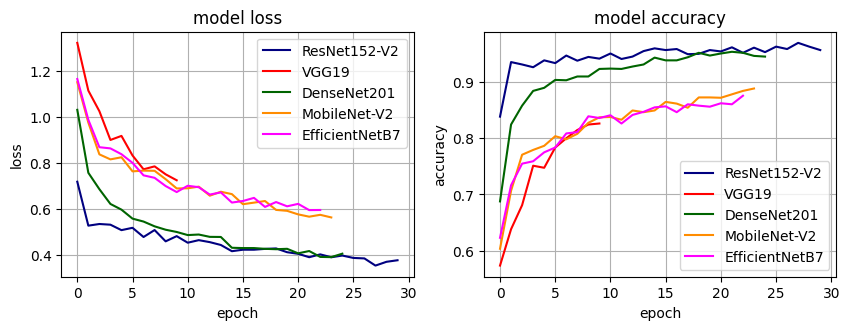

In [43]:

fig = plt.figure(figsize =  (10,7))

plt.subplot(221)

plt.plot(fit_history2.history['loss'], label='ResNet152-V2', color='navy')
plt.plot(fit_history3.history['loss'], label='VGG19', color='red')
plt.plot(fit_history4.history['loss'], label='DenseNet201', color='darkgreen')
plt.plot(fit_history5.history['loss'], label='MobileNet-V2', color='darkorange')
plt.plot(fit_history6.history['loss'], label='EfficientNetB7', color='fuchsia')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.subplot(222)

plt.plot(fit_history2.history['accuracy'], label='ResNet152-V2', color='navy')
plt.plot(fit_history3.history['accuracy'], label='VGG19', color='red')
plt.plot(fit_history4.history['accuracy'], label='DenseNet201', color='darkgreen')
plt.plot(fit_history5.history['accuracy'], label='MobileNet-V2', color='darkorange')
plt.plot(fit_history6.history['accuracy'], label='EfficientNetB7', color='fuchsia')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

plt.show()